# Importing dependencies

## Importing libraries in Google Colab environment

In [1]:
!pip install apriltag

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for apriltag: filename=apriltag-0.0.16-cp310-cp310-linux_x86_64.whl size=511990 sha256=ca955a439224a87de35d09046aaf11e2cecee70fe6d7dcf34530b0e87ac2c6c9
  Stored in directory: /root/.cache/pip/wheels/06/b0/0f/31eead0216b5f1df61d62733b48d7c2247912bfe64808f8ea5
Successfully built apriltag


In [2]:
!python -m pip install --upgrade --force-reinstall numpy-quaternion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 33.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.


In [ ]:
from math import *
import numpy as np
import quaternion
import matplotlib.pyplot as plt
import cv2 as cv
import glob
import apriltag
from google.colab.patches import cv2_imshow

## Importing images and VICON data

In [4]:
vicon = np.genfromtxt('/content/drive/MyDrive/VO_T265/TEST_WITH_VICON/Camera_Vicon_qtrn.csv', delimiter=',')
vicon = np.delete(vicon, [0,1], 0)
vicon.shape

(15710, 9)

In [5]:
file = '/content/drive/MyDrive/VO_T265/TEST_WITH_VICON/cam0/undistorted_png/*.png' 

# Using List Comprehension to read all images
images = [cv.imread(image) for image in glob.glob(file)]

## AprilTag code and visibility check

In [6]:
def getCornerPos(gray):
  '''
  Returns detected tags in the image. If no tags are detected, then returns None
  INPUT: Gray image
  OUTPUT: Detected tag ids, corresponding corners in image coordinates
  '''
  options = apriltag.DetectorOptions(families="tag16h5")
  detector = apriltag.Detector(options)
  results = detector.detect(gray)
  if results == []:
    return None, None

  detected_tags = []
  corresponding_corners = []
  for i in range(len(results)):
    c = results[i].corners.astype(np.int32)
    d = dist(c[0, :], c[2, :])
    if results[i].tag_id <= 11: #and (d >= 100):
      detected_tags.append(results[i].tag_id)
      corresponding_corners.append(c)
  
  if detected_tags == []:
    return None, None

  return detected_tags, corresponding_corners

for j in range(len(images)):
  img = images[j]
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  tags, crnr = getCornerPos(img)
  if tags == None:
    print("No Tags detected in frame:", j)
  else:
    crnr = np.array(crnr)
    cv.polylines(img, crnr, True, (0, 0, 255), thickness = 2)

## Constants and Functions

In [7]:
# CAMERA INTRINSICS MATRIX
fx = 400          # focal length x
fy = 400          # focal length y
cx = 424.5        # image centre x
cy = 400.5        # image centre y
K = np.array([[fx, 0, cx],      # Camera intrinsics
            [0, fy, cy],
            [0, 0, 1]])

def skew_sym(v):
  '''INPUT: 3x1 vector
    OUTPUT: Skew-symmetric form of the input vector
  '''
  if v.size != 3:
    raise ValueError('Input vector must have three elements')
    
  return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])

def RP_from_Homography(Hmg):
  '''INPUT: Homography matrix
    OUTPUT: Rotation matrix and position of world frame w.r.t. camera frame
  '''
  H = np.linalg.inv(K) @ Hmg

  R_cw = np.zeros_like(H)
  R_cw[:, 0] = H[:, 0]
  R_cw[:, 1] = H[:, 1]
  R_cw[:, 2] = skew_sym(H[:, 0]) @ H[:, 1]

  U, S, V_T = np.linalg.svd(R_cw)
  S1 = np.array([[1, 0, 0], [0, 1, 0],[0, 0, np.linalg.det(U @ V_T)]])

  R_cw = U @ S1 @ V_T

  t_cw_in_c = H[:, 2]/np.linalg.norm(H[:, 0])

  return R_cw, t_cw_in_c

def RP2T(R: np.array, p: np.array):
  '''INPUT: Rotation matrix (3x3) and translation vector(3x1)
    OUTPUT: Transformation matrix by combining R and p
  '''
  T = np.append(R, p.reshape(3,1), axis=1)
  T = np.append(T, np.array([[0,0,0,1]]), axis=0)
  return T

def rotm2eulZYX(R):
  '''INPUT: Rotation matrix
    OUTPUT: Array of euler angles in Z-Y-X convention
  '''
  theta_y = np.arctan2(R[0, 2], np.sqrt(R[0, 0]**2 + R[0, 1]**2))
  theta_x = np.arctan2(-R[1, 2], R[2, 2])
  theta_z = np.arctan2(R[1, 0], R[1, 1])

  return np.array([theta_x, theta_y, theta_z])

def eul2rotmZYX(angles):
  '''INPUT: Array of euler angles
    OUTPUT: Rotation matrix in Z-Y-X convention
  '''
  x = angles[0]
  y = angles[1]
  z = angles[2]
  return rotz(z) @ roty(y) @ rotx(x)

def rotx(x):
  '''INPUT: Angle in radians
    OUTPUT: Rotation matrix for rotation about X-axis
  '''
  return np.array([[1, 0, 0],
                [0, np.cos(x), -np.sin(x)],
                [0, np.sin(x), np.cos(x)]])

def roty(y):
  '''INPUT: Angle in radians
    OUTPUT: Rotation matrix for rotation about Y-axis
  '''
  return np.array([[np.cos(y), 0, np.sin(y)],
                [0, 1, 0],
                [-np.sin(y), 0, np.cos(y)]])

def rotz(z):
  '''INPUT: Angle in radians
    OUTPUT: Rotation matrix for rotation about Z-axis
  '''
  return np.array([[np.cos(z), -np.sin(z), 0],
                [np.sin(z), np.cos(z), 0],
                [0, 0, 1]])

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
  '''INPUT: 1D array of data
    OUTPUT: 1D array of smoothened data, using Savitzky-Golay method

    Refer to: Scipy Cookbook - https://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html
  '''
  order_range = range(order+1)
  half_window = (window_size -1) // 2

  # precompute coefficients
  b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
  m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)

  # pad the signal at the extremes with values taken from the signal itself
  firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
  lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
  y = np.concatenate((firstvals, y, lastvals))
  return np.convolve( m[::-1], y, mode='valid')

# Vicon data

## Transforming vicon data in initial frame

In [8]:
# Notations
# w --> world frame in VICON
# v --> vicon frame
# body --> body frame

# Constant transformation T_v2c
R_v2c = rotz(np.pi) @ roty(0) @ rotx(-np.pi/2)
p_v2c = np.zeros(3)
T_v2c = RP2T(R_v2c, p_v2c)

# Constant transformation T_w2v
q = vicon[0, 2:6]
q = np.quaternion(q[3], q[0], q[1], q[2])
R_w2v = quaternion.as_rotation_matrix(q)
p_w2v_in_w = vicon[0, 6:]
T_w2v = RP2T(R_w2v, p_w2v_in_w)


# Initialize
vicon_in_viconframe = np.zeros((len(vicon), 7))
for i in range(len(vicon)):
  # Rotm
  q = vicon[i, 2:6]
  q_w2body = np.quaternion(q[3], q[0], q[1], q[2])
  R_w2body = quaternion.as_rotation_matrix(q_w2body)

  # Position
  p_w2body_in_w = vicon[i, 6:]

  # Combining
  T_w2body = RP2T(R_w2body, p_w2body_in_w)

  # Transformation
  T_v2body = np.linalg.inv(T_w2v) @ T_w2body

  # Extract R|p
  R_v2body = T_v2body[:3, :3]
  p_v2body_in_v = T_v2body[:3, 3]
  
  # Extract q from R
  q_v2body = rotm2eulZYX(R_v2body)

  vicon_in_viconframe[i, 4:7] = q_v2body
  vicon_in_viconframe[i, 1:4] = 0.001*p_v2body_in_v

# Timestamps
vicon_y = np.zeros((len(vicon_in_viconframe)))
k = 0
for i in range(len(vicon_in_viconframe)):
  vicon_y[i] = k
  k += 1/800

vicon_in_viconframe[:, 0] = vicon_y

## Aligning VICON frame with IMU frame

In [9]:
vicon_in_imuframe = np.zeros_like(vicon_in_viconframe)
vicon_in_imuframe[:, 0] = vicon_in_viconframe[:, 0]

R_v2i = rotz(np.pi) @ roty(0) @ rotx(np.pi/2)
for i in range(len(vicon_in_viconframe)):
  q = vicon_in_viconframe[i, 4:7]

  # We can do this only because the origins of both frames co-incide
  vicon_in_imuframe[i, 1] = -vicon_in_viconframe[i, 2]
  vicon_in_imuframe[i, 2] = -vicon_in_viconframe[i, 3]
  vicon_in_imuframe[i, 3] = vicon_in_viconframe[i, 1]
  vicon_in_imuframe[i, 4] = -vicon_in_viconframe[i, 5]
  vicon_in_imuframe[i, 5] = -vicon_in_viconframe[i, 6]
  vicon_in_imuframe[i, 6] = vicon_in_viconframe[i, 4]


# Visual Odometry data

## World coordinates of AprilTags

In [10]:
world_tags = {0:np.array([[0, 34.925], [34.925, 34.925], [34.925, 0], [0, 0]]),
              1:np.array([[52.3875, 34.925], [52.3875+34.925, 34.925], [52.3875+34.925, 0], [52.3875, 0]]),
              2:np.array([[52.3875*2, 34.925], [52.3875*2+34.925, 34.925], [52.3875*2+34.925, 0], [52.3875*2, 0]]),
              3:np.array([[52.3875*3, 34.925], [52.3875*3+34.925, 34.925], [52.3875*3+34.925, 0], [52.3875*3, 0]]),
              4:np.array([[0, 52.3875+34.925], [34.925, 52.3875+34.925], [34.925, 52.3875], [0, 52.3875]]),
              5:np.array([[52.3875, 52.3875+34.925], [52.3875+34.925, 52.3875+34.925], [52.3875+34.925, 52.3875], [52.3875, 52.3875]]),
              6:np.array([[52.3875*2, 52.3875+34.925], [52.3875*2+34.925, 52.3875+34.925], [52.3875*2+34.925, 52.3875], [52.3875*2, 52.3875]]),
              7:np.array([[52.3875*3, 52.3875+34.925], [52.3875*3+34.925, 52.3875+34.925], [52.3875*3+34.925, 52.3875], [52.3875*3, 52.3875]]),
              8:np.array([[0, 52.3875*2+34.925], [34.925, 52.3875*2+34.925], [34.925, 52.3875*2], [0, 52.3875*2]]),
              9:np.array([[52.3875, 52.3875*2+34.925], [52.3875+34.925, 52.3875*2+34.925], [52.3875+34.925, 52.3875*2], [52.3875, 52.3875*2]]),
              10:np.array([[52.3875*2, 52.3875*2+34.925], [52.3875*2+34.925, 52.3875*2+34.925], [52.3875*2+34.925, 52.3875*2], [52.3875*2, 52.3875*2]]),
              11:np.array([[52.3875*3, 52.3875*2+34.925], [52.3875*3+34.925, 52.3875*2+34.925], [52.3875*3+34.925, 52.3875*2], [52.3875*3, 52.3875*2]])}

## Main

In [11]:
# Notations
# b : body frame
# c : camera (first instance of body frame)
# w : world (apriltag) frame

# Rotation from a2c (accelerometer2camera)
R_a2c = rotz(0) @ roty(-np.pi/2) @ rotx(0)

t = [];
e = [];
T_bw_list = [];
for n in range(0, len(images)):
  img = images[n]
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  tags, corners = getCornerPos(gray)
  src = np.zeros((4*len(tags), 2))
  des = np.zeros_like(src)
  for i, id in enumerate(tags):
    world_corners = world_tags[id]
    image_corners = corners[i]
    for r in range(4):
      src[4*i+r, :] = world_corners[r, :]
      des[4*i+r, :] = image_corners[r, :]
    
  Hmg, mask = cv.findHomography(src, des, cv.RANSAC)

  R_bw, t_bw_in_b = RP_from_Homography(Hmg)

  # Transforming to correct frames (CB)
  T_bw = RP2T(R_bw, t_bw_in_b)

  T_bw_list.append(T_bw)

  if n==0:
    T_cw = T_bw

  T_cb = T_cw @ np.linalg.inv(T_bw)

  # Extracting euler angles and positions from rotm
  eul = rotm2eulZYX(T_cb[:3, :3])

  # Aligning axes with IMU frame
  #(We can do it this way only because both frames are attached to the same rigid body)
  temp = eul[0]
  eul[0] = eul[2]
  eul[1] = eul[1]
  eul[2] = -temp

  e.append(eul)

  # Transforming translation in IMU frame
  t.append(0.001*np.linalg.inv(R_a2c) @ T_cb[:3, 3])

# Completing all arrays
t = np.array(t)
e = np.array(e)
pq = np.hstack((t, e))

# Attaching timestamps
timestamps = np.genfromtxt('/content/drive/MyDrive/VO_T265/TEST_WITH_VICON/cam0/data.csv', delimiter=',')
timestamps = (timestamps[:, 0].reshape(len(timestamps), 1) - timestamps[0, 0]) * 1e-9
pq = np.hstack((timestamps, pq))

## Smoothing using Savitzky-Golay method

In [12]:
pq_smooth = np.zeros_like(pq)
pq_smooth[:, 0] = pq[:, 0]
for i in range(1, pq.shape[1]):
  pq_smooth[:, i] = savitzky_golay(pq[:, i], 27, 3)

# IMU data

In [13]:
imu_trajectory = np.genfromtxt('/content/drive/MyDrive/VO_T265/TEST_WITH_VICON/imu0/data.csv', delimiter=',')

# Adjusting timestamps
imu_trajectory[:, 0] = (imu_trajectory[:, 0] - imu_trajectory[0, 0]) * (1e-9)

# Finding correspondences
imu_correspondences = np.zeros((len(pq), 7))
for k, i in enumerate(pq[:, 0]):
  diff = []
  for l, j in enumerate(imu_trajectory[:, 0]):
    diff.append(abs(i - j))

  min_diff_idx = diff.index(min(diff))

  imu_correspondences[k, :] = imu_trajectory[min_diff_idx, :]

# Extended Kalman Filter

## Jacobians

In [14]:
def get_jacobian_x(X, u):
  p1 = X[0]
  p2 = X[1]
  p3 = X[2]
  q1 = X[3]
  q2 = X[4]
  q3 = X[5]
  v1 = X[6]
  v2 = X[7]
  v3 = X[8]
  bg1 = X[9]
  bg2 = X[10]
  bg3 = X[11]
  ba1 = X[12]
  ba2 = X[13]
  ba3 = X[14]
  o1 = u[0]
  o2 = u[1]
  o3 = u[2]
  a1 = u[3]
  a2 = u[4]
  a3 = u[5]
  ng1 = 0
  ng2 = 0
  ng3 = 0
  na1 = 0
  na2 = 0
  na3 = 0

  Jx = np.array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, (-bg2 - ng2 + o2)*(-sin(q1)*sin(q2)**2 - sin(q1)*sin(q3)**2*cos(q2)**2 - sin(q1)*cos(q2)**2*cos(q3)**2)*(4*sin(q1)*sin(q2)**2*sin(q3)**2*cos(q1)*cos(q2) + 4*sin(q1)*sin(q2)**2*cos(q1)*cos(q2)*cos(q3)**2 + 4*sin(q1)*sin(q3)**2*cos(q1)*cos(q2)**3 + 4*sin(q1)*cos(q1)*cos(q2)**3*cos(q3)**2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2)**2 + (-bg2 - ng2 + o2)*(-sin(q2)**2*cos(q1) - sin(q3)**2*cos(q1)*cos(q2)**2 - cos(q1)*cos(q2)**2*cos(q3)**2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2) + (-bg3 - ng3 + o3)*(-sin(q1)*sin(q2)**2 - sin(q1)*sin(q3)**2*cos(q2)**2 - sin(q1)*cos(q2)**2*cos(q3)**2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2) + (-bg3 - ng3 + o3)*(sin(q2)**2*cos(q1) + sin(q3)**2*cos(q1)*cos(q2)**2 + cos(q1)*cos(q2)**2*cos(q3)**2)*(4*sin(q1)*sin(q2)**2*sin(q3)**2*cos(q1)*cos(q2) + 4*sin(q1)*sin(q2)**2*cos(q1)*cos(q2)*cos(q3)**2 + 4*sin(q1)*sin(q3)**2*cos(q1)*cos(q2)**3 + 4*sin(q1)*cos(q1)*cos(q2)**3*cos(q3)**2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2)**2, (-bg1 - ng1 + o1)*(-sin(q3)**2*cos(q2) - cos(q2)*cos(q3)**2 + cos(q2))/(sin(q2)**2*sin(q3)**2 + sin(q2)**2*cos(q3)**2 + sin(q3)**2*cos(q2)**2 + cos(q2)**2*cos(q3)**2) + (-bg2 - ng2 + o2)*(-sin(q1)*sin(q2)**2 - sin(q1)*sin(q3)**2*cos(q2)**2 - sin(q1)*cos(q2)**2*cos(q3)**2)*(-sin(q1)**2*sin(q2)**3*sin(q3)**2 - sin(q1)**2*sin(q2)**3*cos(q3)**2 - sin(q1)**2*sin(q2)*sin(q3)**2*cos(q2)**2 - sin(q1)**2*sin(q2)*cos(q2)**2*cos(q3)**2 + sin(q2)**3*sin(q3)**2*cos(q1)**2 + sin(q2)**3*cos(q1)**2*cos(q3)**2 + sin(q2)*sin(q3)**2*cos(q1)**2*cos(q2)**2 + sin(q2)*cos(q1)**2*cos(q2)**2*cos(q3)**2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2)**2 + (-bg2 - ng2 + o2)*(2*sin(q1)*sin(q2)*sin(q3)**2*cos(q2) + 2*sin(q1)*sin(q2)*cos(q2)*cos(q3)**2 - 2*sin(q1)*sin(q2)*cos(q2))/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2) + (-bg3 - ng3 + o3)*(sin(q2)**2*cos(q1) + sin(q3)**2*cos(q1)*cos(q2)**2 + cos(q1)*cos(q2)**2*cos(q3)**2)*(-sin(q1)**2*sin(q2)**3*sin(q3)**2 - sin(q1)**2*sin(q2)**3*cos(q3)**2 - sin(q1)**2*sin(q2)*sin(q3)**2*cos(q2)**2 - sin(q1)**2*sin(q2)*cos(q2)**2*cos(q3)**2 + sin(q2)**3*sin(q3)**2*cos(q1)**2 + sin(q2)**3*cos(q1)**2*cos(q3)**2 + sin(q2)*sin(q3)**2*cos(q1)**2*cos(q2)**2 + sin(q2)*cos(q1)**2*cos(q2)**2*cos(q3)**2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2)**2 + (-bg3 - ng3 + o3)*(-2*sin(q2)*sin(q3)**2*cos(q1)*cos(q2) - 2*sin(q2)*cos(q1)*cos(q2)*cos(q3)**2 + 2*sin(q2)*cos(q1)*cos(q2))/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2), 0, 0, 0, 0, -(-sin(q2)*sin(q3)**2 - sin(q2)*cos(q3)**2 + sin(q2))/(sin(q2)**2*sin(q3)**2 + sin(q2)**2*cos(q3)**2 + sin(q3)**2*cos(q2)**2 + cos(q2)**2*cos(q3)**2), -(-sin(q1)*sin(q2)**2 - sin(q1)*sin(q3)**2*cos(q2)**2 - sin(q1)*cos(q2)**2*cos(q3)**2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2), -(sin(q2)**2*cos(q1) + sin(q3)**2*cos(q1)*cos(q2)**2 + cos(q1)*cos(q2)**2*cos(q3)**2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2), 0, 0, 0], [0, 0, 0, (-bg2 - ng2 + o2)*(-4*sin(q1)*sin(q2)**2*sin(q3)**4*cos(q1) + 4*sin(q1)*sin(q2)**2*cos(q1)*cos(q3)**4 - 4*sin(q1)*sin(q3)**4*cos(q1)*cos(q2)**2 + 4*sin(q1)*cos(q1)*cos(q2)**2*cos(q3)**4)*(2*sin(q1)*sin(q2)*sin(q3)*cos(q3) - sin(q2)**2*sin(q3)**2*cos(q1) - sin(q2)**2*cos(q1)*cos(q3)**2 - sin(q3)**2*cos(q1)*cos(q2)**2 - cos(q1)*cos(q2)**2*cos(q3)**2)/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4)**2 + (-bg2 - ng2 + o2)*(sin(q1)*sin(q2)**2*sin(q3)**2 + sin(q1)*sin(q2)**2*cos(q3)**2 + sin(q1)*sin(q3)**2*cos(q2)**2 + sin(q1)*cos(q2)**2*cos(q3)**2 + 2*sin(q2)*sin(q3)*cos(q1)*cos(q3))/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4) + (-bg3 - ng3 + o3)*(-4*sin(q1)*sin(q2)**2*sin(q3)**4*cos(q1) + 4*sin(q1)*sin(q2)**2*cos(q1)*cos(q3)**4 - 4*sin(q1)*sin(q3)**4*cos(q1)*cos(q2)**2 + 4*sin(q1)*cos(q1)*cos(q2)**2*cos(q3)**4)*(sin(q1)*sin(q2)**2*sin(q3)**2 + sin(q1)*sin(q2)**2*cos(q3)**2 + sin(q1)*sin(q3)**2*cos(q2)**2 + sin(q1)*cos(q2)**2*cos(q3)**2 - 2*sin(q2)*sin(q3)*cos(q1)*cos(q3))/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4)**2 + (-bg3 - ng3 + o3)*(2*sin(q1)*sin(q2)*sin(q3)*cos(q3) + sin(q2)**2*sin(q3)**2*cos(q1) + sin(q2)**2*cos(q1)*cos(q3)**2 + sin(q3)**2*cos(q1)*cos(q2)**2 + cos(q1)*cos(q2)**2*cos(q3)**2)/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4), 2*(-bg1 - ng1 + o1)*sin(q2)*sin(q3)*cos(q3)/(-sin(q2)**2*sin(q3)**4 + sin(q2)**2*cos(q3)**4 - sin(q3)**4*cos(q2)**2 + cos(q2)**2*cos(q3)**4) + 2*(-bg2 - ng2 + o2)*sin(q1)*sin(q3)*cos(q2)*cos(q3)/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4) - 2*(-bg3 - ng3 + o3)*sin(q3)*cos(q1)*cos(q2)*cos(q3)/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4), (-2*sin(q1)*sin(q2)*sin(q3)**2 + 2*sin(q1)*sin(q2)*cos(q3)**2)*(-bg2 - ng2 + o2)/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4) + (2*sin(q2)*sin(q3)**2*cos(q1) - 2*sin(q2)*cos(q1)*cos(q3)**2)*(-bg3 - ng3 + o3)/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4) + 2*(-bg1 - ng1 + o1)*sin(q3)**2*cos(q2)/(-sin(q2)**2*sin(q3)**4 + sin(q2)**2*cos(q3)**4 - sin(q3)**4*cos(q2)**2 + cos(q2)**2*cos(q3)**4) - 2*(-bg1 - ng1 + o1)*cos(q2)*cos(q3)**2/(-sin(q2)**2*sin(q3)**4 + sin(q2)**2*cos(q3)**4 - sin(q3)**4*cos(q2)**2 + cos(q2)**2*cos(q3)**4) - 2*(-bg1 - ng1 + o1)*(4*sin(q2)**2*sin(q3)**3*cos(q3) + 4*sin(q2)**2*sin(q3)*cos(q3)**3 + 4*sin(q3)**3*cos(q2)**2*cos(q3) + 4*sin(q3)*cos(q2)**2*cos(q3)**3)*sin(q3)*cos(q2)*cos(q3)/(-sin(q2)**2*sin(q3)**4 + sin(q2)**2*cos(q3)**4 - sin(q3)**4*cos(q2)**2 + cos(q2)**2*cos(q3)**4)**2 + (-bg2 - ng2 + o2)*(2*sin(q1)*sin(q2)*sin(q3)*cos(q3) - sin(q2)**2*sin(q3)**2*cos(q1) - sin(q2)**2*cos(q1)*cos(q3)**2 - sin(q3)**2*cos(q1)*cos(q2)**2 - cos(q1)*cos(q2)**2*cos(q3)**2)*(-4*sin(q1)**2*sin(q2)**2*sin(q3)**3*cos(q3) - 4*sin(q1)**2*sin(q2)**2*sin(q3)*cos(q3)**3 - 4*sin(q1)**2*sin(q3)**3*cos(q2)**2*cos(q3) - 4*sin(q1)**2*sin(q3)*cos(q2)**2*cos(q3)**3 + 4*sin(q2)**2*sin(q3)**3*cos(q1)**2*cos(q3) + 4*sin(q2)**2*sin(q3)*cos(q1)**2*cos(q3)**3 + 4*sin(q3)**3*cos(q1)**2*cos(q2)**2*cos(q3) + 4*sin(q3)*cos(q1)**2*cos(q2)**2*cos(q3)**3)/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4)**2 + (-bg3 - ng3 + o3)*(sin(q1)*sin(q2)**2*sin(q3)**2 + sin(q1)*sin(q2)**2*cos(q3)**2 + sin(q1)*sin(q3)**2*cos(q2)**2 + sin(q1)*cos(q2)**2*cos(q3)**2 - 2*sin(q2)*sin(q3)*cos(q1)*cos(q3))*(-4*sin(q1)**2*sin(q2)**2*sin(q3)**3*cos(q3) - 4*sin(q1)**2*sin(q2)**2*sin(q3)*cos(q3)**3 - 4*sin(q1)**2*sin(q3)**3*cos(q2)**2*cos(q3) - 4*sin(q1)**2*sin(q3)*cos(q2)**2*cos(q3)**3 + 4*sin(q2)**2*sin(q3)**3*cos(q1)**2*cos(q3) + 4*sin(q2)**2*sin(q3)*cos(q1)**2*cos(q3)**3 + 4*sin(q3)**3*cos(q1)**2*cos(q2)**2*cos(q3) + 4*sin(q3)*cos(q1)**2*cos(q2)**2*cos(q3)**3)/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4)**2, 0, 0, 0, 2*sin(q3)*cos(q2)*cos(q3)/(-sin(q2)**2*sin(q3)**4 + sin(q2)**2*cos(q3)**4 - sin(q3)**4*cos(q2)**2 + cos(q2)**2*cos(q3)**4), -(2*sin(q1)*sin(q2)*sin(q3)*cos(q3) - sin(q2)**2*sin(q3)**2*cos(q1) - sin(q2)**2*cos(q1)*cos(q3)**2 - sin(q3)**2*cos(q1)*cos(q2)**2 - cos(q1)*cos(q2)**2*cos(q3)**2)/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4), -(sin(q1)*sin(q2)**2*sin(q3)**2 + sin(q1)*sin(q2)**2*cos(q3)**2 + sin(q1)*sin(q3)**2*cos(q2)**2 + sin(q1)*cos(q2)**2*cos(q3)**2 - 2*sin(q2)*sin(q3)*cos(q1)*cos(q3))/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4), 0, 0, 0], [0, 0, 0, -(-bg2 - ng2 + o2)*(4*sin(q1)*sin(q2)**2*sin(q3)**2*cos(q1)*cos(q2) + 4*sin(q1)*sin(q2)**2*cos(q1)*cos(q2)*cos(q3)**2 + 4*sin(q1)*sin(q3)**2*cos(q1)*cos(q2)**3 + 4*sin(q1)*cos(q1)*cos(q2)**3*cos(q3)**2)*sin(q1)*sin(q2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2)**2 - (-bg2 - ng2 + o2)*sin(q2)*cos(q1)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2) + (-bg3 - ng3 + o3)*(4*sin(q1)*sin(q2)**2*sin(q3)**2*cos(q1)*cos(q2) + 4*sin(q1)*sin(q2)**2*cos(q1)*cos(q2)*cos(q3)**2 + 4*sin(q1)*sin(q3)**2*cos(q1)*cos(q2)**3 + 4*sin(q1)*cos(q1)*cos(q2)**3*cos(q3)**2)*sin(q2)*cos(q1)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2)**2 - (-bg3 - ng3 + o3)*sin(q1)*sin(q2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2), -(-bg2 - ng2 + o2)*(-sin(q1)**2*sin(q2)**3*sin(q3)**2 - sin(q1)**2*sin(q2)**3*cos(q3)**2 - sin(q1)**2*sin(q2)*sin(q3)**2*cos(q2)**2 - sin(q1)**2*sin(q2)*cos(q2)**2*cos(q3)**2 + sin(q2)**3*sin(q3)**2*cos(q1)**2 + sin(q2)**3*cos(q1)**2*cos(q3)**2 + sin(q2)*sin(q3)**2*cos(q1)**2*cos(q2)**2 + sin(q2)*cos(q1)**2*cos(q2)**2*cos(q3)**2)*sin(q1)*sin(q2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2)**2 - (-bg2 - ng2 + o2)*sin(q1)*cos(q2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2) + (-bg3 - ng3 + o3)*(-sin(q1)**2*sin(q2)**3*sin(q3)**2 - sin(q1)**2*sin(q2)**3*cos(q3)**2 - sin(q1)**2*sin(q2)*sin(q3)**2*cos(q2)**2 - sin(q1)**2*sin(q2)*cos(q2)**2*cos(q3)**2 + sin(q2)**3*sin(q3)**2*cos(q1)**2 + sin(q2)**3*cos(q1)**2*cos(q3)**2 + sin(q2)*sin(q3)**2*cos(q1)**2*cos(q2)**2 + sin(q2)*cos(q1)**2*cos(q2)**2*cos(q3)**2)*sin(q2)*cos(q1)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2)**2 + (-bg3 - ng3 + o3)*cos(q1)*cos(q2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2), 0, 0, 0, 0, -1/(sin(q2)**2*sin(q3)**2 + sin(q2)**2*cos(q3)**2 + sin(q3)**2*cos(q2)**2 + cos(q2)**2*cos(q3)**2), sin(q1)*sin(q2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2), -sin(q2)*cos(q1)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2), 0, 0, 0], [0, 0, 0, (sin(q1)*sin(q3) + sin(q2)*cos(q1)*cos(q3))*(a2 - ba2 - na2) + (-sin(q1)*sin(q2)*cos(q3) - sin(q3)*cos(q1))*(a3 - ba3 - na3), -(a1 - ba1 - na1)*sin(q2)*cos(q3) + (a2 - ba2 - na2)*sin(q1)*cos(q2)*cos(q3) + (a3 - ba3 - na3)*cos(q1)*cos(q2)*cos(q3), (-sin(q1)*cos(q3) - sin(q2)*sin(q3)*cos(q1))*(a3 - ba3 - na3) + (-sin(q1)*sin(q2)*sin(q3) - cos(q1)*cos(q3))*(a2 - ba2 - na2) - (a1 - ba1 - na1)*sin(q3)*cos(q2), 0, 0, 0, 0, 0, 0, -cos(q2)*cos(q3), -sin(q1)*sin(q2)*cos(q3) + sin(q3)*cos(q1), sin(q1)*sin(q3) - sin(q2)*cos(q1)*cos(q3)], [0, 0, 0, (sin(q1)*cos(q3) + sin(q2)*sin(q3)*cos(q1))*(a2 - ba2 - na2) + (-sin(q1)*sin(q2)*sin(q3) - cos(q1)*cos(q3))*(a3 - ba3 - na3), -(a1 - ba1 - na1)*sin(q2)*sin(q3) + (a2 - ba2 - na2)*sin(q1)*sin(q3)*cos(q2) + (a3 - ba3 - na3)*sin(q3)*cos(q1)*cos(q2), (sin(q1)*sin(q3) + sin(q2)*cos(q1)*cos(q3))*(a3 - ba3 - na3) + (sin(q1)*sin(q2)*cos(q3) + sin(q3)*cos(q1))*(a2 - ba2 - na2) + (a1 - ba1 - na1)*cos(q2)*cos(q3), 0, 0, 0, 0, 0, 0, -sin(q3)*cos(q2), -sin(q1)*sin(q2)*sin(q3) + cos(q1)*cos(q3), sin(q1)*cos(q3) - sin(q2)*sin(q3)*cos(q1)], [0, 0, 0, (a2 - ba2 - na2)*cos(q1)*cos(q2) - (a3 - ba3 - na3)*sin(q1)*cos(q2), (-a1 + ba1 + na1)*cos(q2) - (a2 - ba2 - na2)*sin(q1)*sin(q2) - (a3 - ba3 - na3)*sin(q2)*cos(q1), 0, 0, 0, 0, 0, 0, 0, sin(q2), -sin(q1)*cos(q2), -cos(q1)*cos(q2)], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])



  return Jx

def get_jacobian_n(X, u):
  p1 = X[0]
  p2 = X[1]
  p3 = X[2]
  q1 = X[3]
  q2 = X[4]
  q3 = X[5]
  v1 = X[6]
  v2 = X[7]
  v3 = X[8]
  bg1 = X[9]
  bg2 = X[10]
  bg3 = X[11]
  ba1 = X[12]
  ba2 = X[13]
  ba3 = X[14]
  o1 = u[0]
  o2 = u[1]
  o3 = u[2]
  a1 = u[3]
  a2 = u[4]
  a3 = u[5]
  ng1 = 0
  ng2 = 0
  ng3 = 0
  na1 = 0
  na2 = 0
  na3 = 0

  Jn = np.array([[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [-(-sin(q2)*sin(q3)**2 - sin(q2)*cos(q3)**2 + sin(q2))/(sin(q2)**2*sin(q3)**2 + sin(q2)**2*cos(q3)**2 + sin(q3)**2*cos(q2)**2 + cos(q2)**2*cos(q3)**2), -(-sin(q1)*sin(q2)**2 - sin(q1)*sin(q3)**2*cos(q2)**2 - sin(q1)*cos(q2)**2*cos(q3)**2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2), -(sin(q2)**2*cos(q1) + sin(q3)**2*cos(q1)*cos(q2)**2 + cos(q1)*cos(q2)**2*cos(q3)**2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2), 0, 0, 0], [2*sin(q3)*cos(q2)*cos(q3)/(-sin(q2)**2*sin(q3)**4 + sin(q2)**2*cos(q3)**4 - sin(q3)**4*cos(q2)**2 + cos(q2)**2*cos(q3)**4), -(2*sin(q1)*sin(q2)*sin(q3)*cos(q3) - sin(q2)**2*sin(q3)**2*cos(q1) - sin(q2)**2*cos(q1)*cos(q3)**2 - sin(q3)**2*cos(q1)*cos(q2)**2 - cos(q1)*cos(q2)**2*cos(q3)**2)/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4), -(sin(q1)*sin(q2)**2*sin(q3)**2 + sin(q1)*sin(q2)**2*cos(q3)**2 + sin(q1)*sin(q3)**2*cos(q2)**2 + sin(q1)*cos(q2)**2*cos(q3)**2 - 2*sin(q2)*sin(q3)*cos(q1)*cos(q3))/(sin(q1)**2*sin(q2)**2*sin(q3)**4 - sin(q1)**2*sin(q2)**2*cos(q3)**4 + sin(q1)**2*sin(q3)**4*cos(q2)**2 - sin(q1)**2*cos(q2)**2*cos(q3)**4 - sin(q2)**2*sin(q3)**4*cos(q1)**2 + sin(q2)**2*cos(q1)**2*cos(q3)**4 - sin(q3)**4*cos(q1)**2*cos(q2)**2 + cos(q1)**2*cos(q2)**2*cos(q3)**4), 0, 0, 0], [-1/(sin(q2)**2*sin(q3)**2 + sin(q2)**2*cos(q3)**2 + sin(q3)**2*cos(q2)**2 + cos(q2)**2*cos(q3)**2), sin(q1)*sin(q2)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2), -sin(q2)*cos(q1)/(-sin(q1)**2*sin(q2)**2*sin(q3)**2*cos(q2) - sin(q1)**2*sin(q2)**2*cos(q2)*cos(q3)**2 - sin(q1)**2*sin(q3)**2*cos(q2)**3 - sin(q1)**2*cos(q2)**3*cos(q3)**2 + sin(q2)**2*sin(q3)**2*cos(q1)**2*cos(q2) + sin(q2)**2*cos(q1)**2*cos(q2)*cos(q3)**2 + sin(q3)**2*cos(q1)**2*cos(q2)**3 + cos(q1)**2*cos(q2)**3*cos(q3)**2), 0, 0, 0], [0, 0, 0, -cos(q2)*cos(q3), -sin(q1)*sin(q2)*cos(q3) + sin(q3)*cos(q1), sin(q1)*sin(q3) - sin(q2)*cos(q1)*cos(q3)], [0, 0, 0, -sin(q3)*cos(q2), -sin(q1)*sin(q2)*sin(q3) + cos(q1)*cos(q3), sin(q1)*cos(q3) - sin(q2)*sin(q3)*cos(q1)], [0, 0, 0, sin(q2), -sin(q1)*cos(q2), -cos(q1)*cos(q2)], [1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])

  return Jn


## Functions

In [15]:
def get_rotm_from_euler(q):
  "ZYX"
  x = q[0]
  y = q[1]
  z = q[2]
  R = np.array([[np.cos(z)*np.cos(y), np.cos(z)*np.sin(y)*np.sin(x) - np.sin(z)*np.cos(x), np.cos(z)*np.sin(y)*np.cos(x) - np.sin(z)*np.sin(x)],
                [np.sin(z)*np.cos(y), np.sin(z)*np.sin(y)*np.sin(x) - np.cos(z)*np.cos(x), np.sin(z)*np.sin(y)*np.cos(x) - np.cos(z)*np.sin(x)],
                [-np.sin(y), np.cos(y)*np.sin(x), np.cos(y)*np.cos(x)]])
  return R

def transition_function(x, u, n):         # x_dot = f(x, u, n)
  
  # Initialize R
  q = x[3:6]
  R = get_rotm_from_euler(q)

  G1 = np.array([[0, -np.sin(q[2]), np.cos(q[1]) * np.cos(q[2])],
                  [0, np.cos(q[2]), np.cos(q[1]) * np.sin(q[2])],
                  [1, 0, -np.sin(q[1])]])

  G = R.T @ G1

  # Elements of x_dot
  p_dot = x[6:9]
  q_dot = np.linalg.inv(G) @ (u[:3] - x[9:12] - n[:3])
  v_dot = np.array([0, -9.81, 0]) + R @ (u[3:6] - x[12:15] - n[3:6])
  bg_dot = np.zeros(3)
  ba_dot = np.zeros_like(bg_dot)

  x_dot = np.array([p_dot, q_dot, v_dot, bg_dot, ba_dot])
  x_dot = x_dot.reshape((15,))
  return x_dot

def prediction_step(x_prev, u, covar_prev, dt):
  # Noise
  Q_diag = np.array([0.0006899523354520224, 0.0001738504141914649, 0.00012892674537746693, 0.002474436867434773, 0.003341363324205506, 0.007756204871691255])
  Q = np.diag(Q_diag)*dt

  # Linearize
  A = get_jacobian_x(x_prev, u)
  U = get_jacobian_n(x_prev, u)

  # Discretize
  F = np.identity(15) + dt*A

  # Predictions
  x_pred = x_prev + dt * transition_function(x_prev, u, np.array([0,0,0,0,0,0]))
  covar_pred = F @ covar_prev @ F.T + U @ Q @ U.T

  return x_pred, covar_pred

def update_step(z, x_pred, covar_pred):
  # C = [I 0 0 0 0]
  #     [0 I 0 0 0]
  C = np.zeros((6, 15))
  for i in range(6):
    C[i, i] = 1

  # Noise
  R_diag = np.array([4.825194012029564e-07, 2.0302655149943722e-07, 1.64805593189721e-07, 1.2923504903951793e-05, 7.129663223163056e-06, 5.678951145001381e-06])
  R_m = np.diag(R_diag)

  # Kalman gain
  K = covar_pred @ C.T @ np.linalg.inv(C @ covar_pred @ C.T + R_m)

  # Corrected value
  x_corrected = x_pred + K @ (z - C @ x_pred)
  covar_corrected = covar_pred - K @ C @ covar_pred

  return x_corrected, covar_corrected


## Main

In [16]:
mean_state = np.zeros(15)
covar = np.eye(15)
vio_trajectory = np.zeros((np.size(pq_smooth, 0), 16))

#timestamps
vio_trajectory[:, 0] = pq_smooth [:, 0]

for i in range(1, np.size(pq_smooth, 0)):
  
  # Time difference
  dt = (imu_correspondences[i, 0] - imu_correspondences[i-1, 0])     # Considering timestamps of IMU and not VO bcos pred model based in IMU.

  # Prediction step
  mu, covar = prediction_step(mean_state, imu_correspondences[i, 1:], covar, dt)

  # Update step
  z_m = pq_smooth[i, 1:]
  mu, covar = update_step(z_m, mu, covar)

  #Record fused values
  vio_trajectory[i, 1:] = mu

  #Passing the baton
  mean_state = mu
  covar = covar

# Visualization

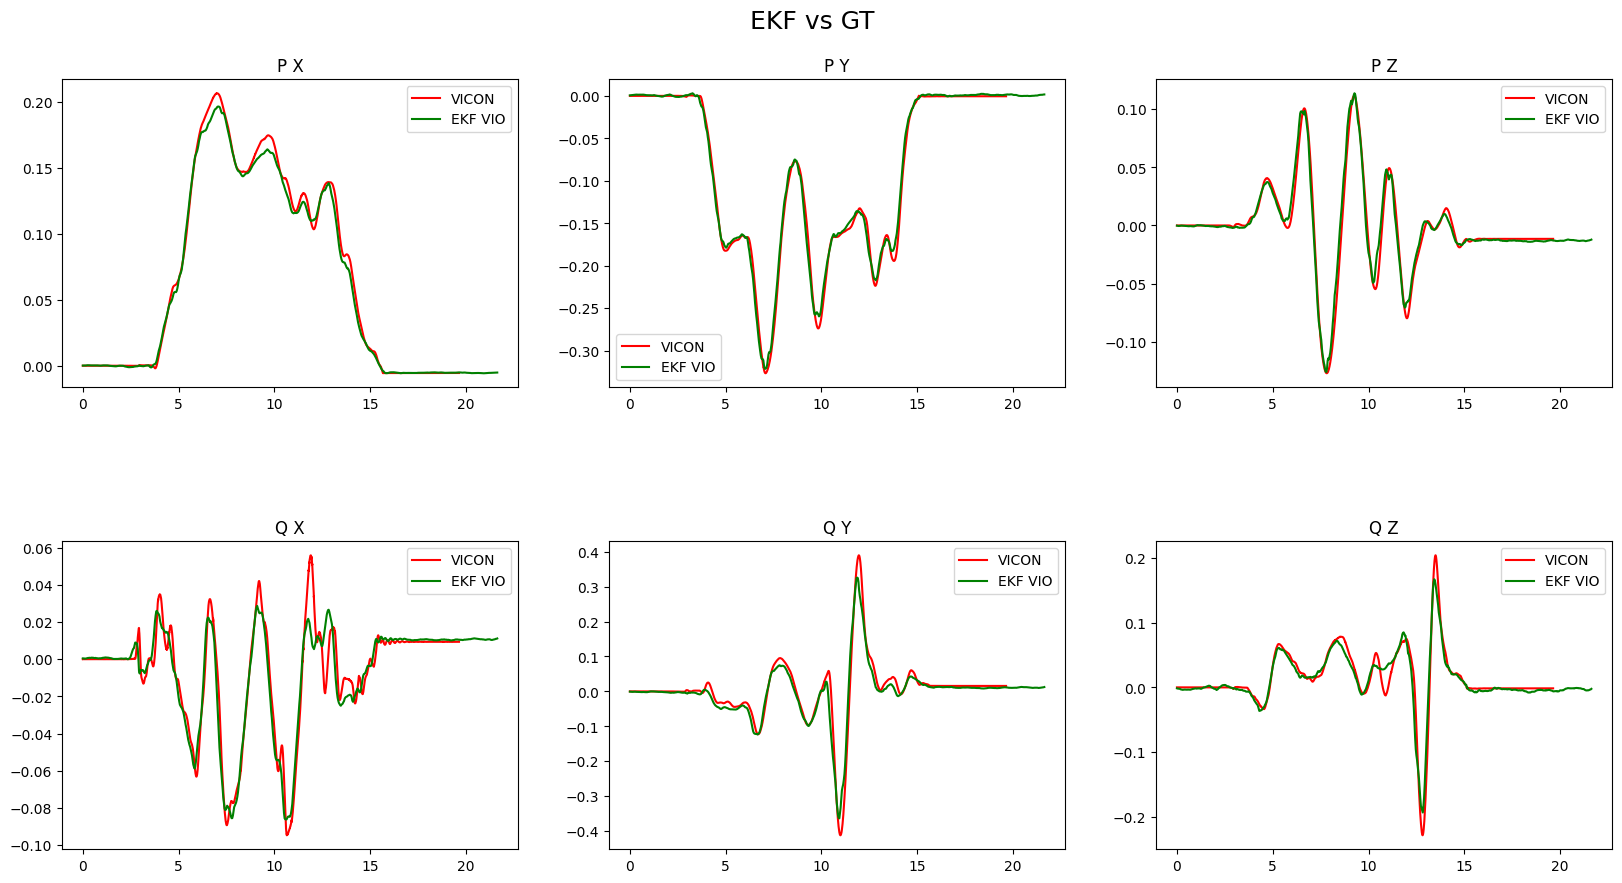

In [17]:
#@title Plots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("EKF vs GT", fontsize=18, y=0.95)
tickers = ["P X", "P Y", "P Z", "q X", "q Y", "q Z"]
i = 1

for ticker, ax in zip(tickers, axs.ravel()):

    ax.plot(vicon_in_imuframe[:, 0], vicon_in_imuframe[:, i], 'r', label="VICON")
    ax.plot(vio_trajectory[:-96, 0], vio_trajectory[96:, i], 'g', label="EKF VIO")

    ax.legend(loc = "best")

    # chart formatting
    ax.set_title(ticker.upper())
    ax.set_xlabel("")

    i+=1

plt.show()